# Prosodic and Bruce Hayes' annotations of Shakespeare and Milton

In [1]:
import sys,os
sys.path.insert(0,os.path.abspath('../prosodic'))
sys.path.insert(0,os.path.abspath('../cadence'))
import cadence as cd
from cadence.imports import *
import plotnine as p9
import prosodic as p
p.config['print_to_screen']=0
SCORECOL_HAYES='Score (Author A bottom-up coding)'

## Gathering data

### Hayes' data

In [2]:
@cache
def read_hayes_df():
    return pd.read_csv(
        'https://linguistics.ucla.edu/people/hayes/ShakespeareAndMilton/ShakespeareTableaux.txt',
        sep='\t', 
        header=7
    )

read_hayes_df()

,Sonnet,Line Number,Line,Computer coding,Score (Author A bottom-up coding),Stated in features for computer code,"*[+Strong,-J2]","*[+Strong,-J3]","*[+Strong,-J4]","*[+Strong,-J5]",*[-J5][+wb],*[-J4][+wb],*[-J3][+wb],*[-J2][+wb],"*[-Strong,+J5][]","*[-Strong,+J4][]","*[-Strong,+J3][]","*[-Strong,+J2][]","*[+J5,+Realsyl][]","*[+J4,+Realsyl][]","*[+J3,+Realsyl][]","*[+J2,+Realsyl][]",*[-Realsyl][+J5],*[-Realsyl][+J4],*[-Realsyl][+J3],*[-Realsyl][+J2],*[+J5][][+wb],*[+J4][][+wb],*[+J3][][+wb],*[+J2][][+wb],"*[-Strong,+Accent]","*[+Strong,-Accent]","*[+Strong,+Rise]","*[-Strong,+Fall]","*[+Strong,-Fall][]","*[-Strong,-Rise][]","*[-Accent][-Strong,+Accent]","*[-Strong,+Accent][-Accent]","*[+Strong,+Rise,-J2]","*[-Strong,+Accent,-J2]",...,"*[+Strong,+Rise,-J5][+Fall,-J5]","*[+Strong,+Rise,-J4][+Fall,-J4]","*[+Strong,+Rise,-J3][+Fall,-J3]","*[+Strong,+Rise,-J2][+Fall,-J2]","*[+Strong,-Accent][+Accent][-Accent]","*[+Strong,-Accent,-J5][+Accent,-J5][-Accent]","*[+Strong,-Accent,-J4][+Accent,-J4][-Accent]","*[+Strong,-Accent,-J3][+Accent,-J3][-Accent]","*[+Strong,+Rise,-J2][][-Accent]","*[-Accent][-Strong,+Accent,-J2]","*[+Strong,+Rise,-J2][-J5][-Accent]","*[-Accent,-J5][-Strong,+Accent,-J2]","*[+Strong,+Rise,-J2][-J4][-Accent]","*[-Accent,-J4][-Strong,+Accent,-J2]","*[+Strong,+Rise,-J2][-J3][-Accent]","*[-Accent,-J3][-Strong,+Accent,-J2]","*[+Strong,-Accent][][+Strong,-Accent]",*[-Strong][+wb],*[-Fall][-Strong][+wb],"*[-Strong,+Accent][+wb]",*[+J2][-Strong][+wb],"*[-Strong,-J5][+wb]","*[-Strong,-J4][+wb]","*[-J5][-Strong,+Accent,-J2]","*[-J4][-Strong,+Accent,-J2]","*[-J3][-Strong,+Accent,-J2]","*[-J5][-Strong,+Fall,-J3]","*[-J4][-Strong,+Fall,-J3]","*[-J5][-Strong,+Fall]","*[-J4][-Strong,+Fall]","*[-J3][-Strong,+Fall]","*[+Realsyl][-Strong,+Accent,-J2]","*[+Realsyl][-Strong,+Fall]","*[+Strong,+Accent,-J4][+Fall,-J2]","*[+Strong,+Accent,-J4][+Fall,-J3]","*[+J3][-Accent,+J3]","*[+J4][-Accent,+J4]","*[+J5][-Accent,+J5]","*[-Accent,-J2][-Accent,-J2][-Accent]","*[+J2][-Accent,-J2][-Accent,-J2]"
0,1,1,"From fairest creatures we desire increase,",LB5 MwUuJ2 MsSdJ1 MwUuJ3 MsSdJ1 MwUlJ3 MsUlJ2 ...,0.28,NaN,2.0,3.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3,NaN,NaN,3,5,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,"That thereby beauty's rose might never die,",LB5 MwUuJ2 MsSdJ2 MwSuJ3 MsSdJ1 MwUuJ4 MsSdJ4 ...,3.73,NaN,2.0,3.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,1.0,3.0,5,NaN,2.0,4,7,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,"But as the riper should by time decease,",LB5 MwUlJ2 MsUlJ2 MwUuJ2 MsSdJ1 MwUlJ4 MsUlJ2 ...,1.35,NaN,1.0,3.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,4,NaN,2.0,2,7,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,His tender heir might bear his memory:,LB5 MwUuJ2 MsSdJ1 MwUuJ3 MsSdJ4 MwUuJ2 MsSdJ3 ...,1.87,NaN,2.0,2.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4,NaN,1.0,3,6,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,"But thou contracted to thine own bright eyes,",LB5 MwUlJ2 MsUlJ2 MwUuJ1 MsSdJ1 MwUlJ3 MsUlJ2 ...,3.78,NaN,1.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4,NaN,NaN,2,7,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,2.0,1.0,NaN,3.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

### Data parsed via [cadence](https://github.com/quadrismegistus/cadence)

In [3]:

def getparses(fn='data.parsed.shakespeare.pkl',scorecol=SCORECOL_HAYES):
    if not os.path.exists(fn):
        df = read_hayes_df()
        print(df.columns)
        txt='\n'.join(df.Line)
        t = cd.Verse(txt)
        dfparses = t.parse(verbose=False, num_proc=8)    
        dfl = to_lines(dfparses, only_best=False)
        dfl.to_pickle(fn)
    else:
        dfl=pd.read_pickle(fn)

    df = read_hayes_df()
    dfl['hayes_score'] = [df.iloc[i-1][scorecol] for i in dfl.index.get_level_values('unit_i')]
    return dfl

# getparses()

In [4]:
def getparses_stats():
    dfl = getparses()
    dflq = dfl.groupby('unit_i').mean()
    return dflq

# getparses_stats()

#### Which best correlates?

In [5]:
# getparses_stats().corr().hayes_score.sort_values(ascending=False)

### Data parsed via [prosodic](https://github.com/quadrismegistus/prosodic)

In [45]:
def getparses_prosodic(fn='data.parsed.shakespeare.prosodic.pkl', force=False, meter='default_english', scorecol=SCORECOL_HAYES, save=False, save_fn='data.parses.shakespeare.prosodic.2023.csv'):
    if force or not os.path.exists(fn):
        df = read_hayes_df()
        txt='\n'.join(df.Line)
        t = p.Text(txt, phrasebreak='line', name='shakespeare_hayes')
        t.parse(meter=meter)
        dfl = t.parse_data(meter=meter)
        dfl.to_pickle(fn)
    else:
        dfl=pd.read_pickle(fn)

    df = read_hayes_df()
    dfl['hayes_score'] = [df.iloc[i-1][scorecol] for i in dfl.line_num]

    if save:
        dfl.drop('stanza_num',axis=1).set_index('line_num').to_csv(save_fn)
        print('saved:',os.path.abspath(save_fn))
    return dfl


In [46]:
getparses_prosodic(save=True)

saved: /Users/ryan/github/antimetrical/data.parses.shakespeare.prosodic.2023.csv


,stanza_num,line,line_num,parse,parse_all,meter,meter_all,num_parses,num_viols__bestparse,num_viols__allparses_sum,num_viols__allparses_mean,score_viols__bestparse,score_viols__allparses_sum,score_viols__allparses_mean,num_sylls,num_words,[*strength.w=>-p/1]__bestparse,[*strength.w=>-p/1]__allparses_sum,[*strength.w=>-p/1]__allparses_mean,[*stress.s=>-u/1]__bestparse,[*stress.s=>-u/1]__allparses_sum,[*stress.s=>-u/1]__allparses_mean,[*stress.w=>-p/1]__bestparse,[*stress.w=>-p/1]__allparses_sum,[*stress.w=>-p/1]__allparses_mean,[*footmin-w-resolution/1]__bestparse,[*footmin-w-resolution/1]__allparses_sum,[*footmin-w-resolution/1]__allparses_mean,[*footmin-f-resolution/1]__bestparse,[*footmin-f-resolution/1]__allparses_sum,[*footmin-f-resolution/1]__allparses_mean,hayes_score
0,1,"From fairest creatures we desire increase,",1,from|FAI|rest|CREA|tures|WE|de|SIRE|in|CREASE,from|FAI|rest|CREA|tures|WE|de|SIRE|in|CREASE,wswswswsws,wswswswsws,1,0,0,0.000000,0,0,0.000000,10,6,0,0,0.0,0,0,0.000000,0,0,0.000000,0,0,0.000000,0,0,0.000000,0.28
1,1,"That thereby beauty's rose might never die,",2,that|THE|reby*|BEA|uty's|ROSE|might|NE|ver|DIE,that|THE|reby*|BEA|uty's|ROSE|might|NE|ver|DIE,wswswswsws,wswswswsws,1,1,1,1.000000,1,1,1.000000,10,7,0,0,0.0,0,0,0.000000,1,1,1.000000,0,0,0.000000,0,0,0.000000,3.73
2,1,"But as the riper should by time decease,",3,BUT*|as.the|RI|per|SHOULD|by|TIME|de|CEASE,BUT*|as.the|RI|per|SHOULD|by|TIME|de|CEASE ...,swwswswsws,swwswswsws wswswswsws,2,1,2,1.000000,1,2,1.000000,10,8,0,0,0.0,1,2,1.000000,0,0,0.000000,0,0,0.000000,0,0,0.000000,1.35
3,1,His tender heir might bear his memory:,4,his|TEN|der|HEIR|might|BEAR|his|ME|mo|RY*,his|TEN|der|HEIR|might|BEAR|his|ME|mo|RY* h...,wswswswsws,wswswswsws wswswswsww wswswswssw,3,1,3,1.000000,1,3,1.000000,10,7,0,0,0.0,1,2,0.666667,0,0,0.000000,0,1,0.333333,0,0,0.000000,1.87
4,1,"But thou contracted to thine own bright eyes,",5,but.thou|CON|trac|TED*|to.thine|OWN|bright*|EYES,but.thou|CON|trac|TED*|to.thine|OWN|bright*|EY...,wwswswwsws,wwswswwsws wswswswwss wwswswswss wwsw...,5,2,14,2.800000,2,14,2.800000,10,8,0,0,0.0,1,7,1.400000,1,1,0.200000,0,1,0.200000,0,5,1.000000,3.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,1,"Which from Love's fire took heat perpetual,",2137,WHICH|from|LOVE'S.FI*|re|TOOK.HEAT*|per|PE|tual,WHICH|from|LOVE'S.FI*|re|TOOK.HEAT*|per|PE|tua...,swsswsswsw,swsswsswsw swswsswsw swswwswsw swssws...,9,2,19,2.111111,2,19,2.111111,10,7,0,0,0.0,0,1,0.111111,0,8,0.888889,0,0,0.000000,2,10,1.111111,8.63
2137,1,"Growing a bath and healthful remedy,",2138,GRO|wing.a*|BATH|and|HEALT|hful|RE|me|DY*,GRO|wing.a*|BATH|and|HEALT|hful|RE|me|DY* G...,swwswswsws,swwswswsws swwswswsww swwswswssw ssws...,6,2,12,2.000000,2,12,2.000000,10,6,0,0,0.0,1,7,1.166667,0,0,0.000000,0,2,0.333333,1,3,0.500000,5.09
2138,1,"For men diseas'd; but I, my mistress' thrall,",2139,for|MEN|di*|SEAS'D|but|I|my|MIS|tress|THRALL,for|MEN|di*|SEAS'D|but|I|my|MIS|tress|THRALL,wswswswsws,wswswswsws,1,1,1,1.000000,1,1,1.000000,10,8,0,0,0.0,0,0,0.000000,1,1,1.000000,0,0,0.000000,0,0,0.000000,1.83
2139,1,"Came there for cure and this by that I prove,",2140,CAME|there.for|CURE|and|THIS*|by|THAT|i|PROVE,CAME|there.for|CURE|and|THIS*|by|THAT|i|PROVE ...,swwswswsws,swwswswsws swwswwswws,2,1,2,1.000000,1,2,1.000000,10,10,0,0,0.0,1,2,1.000000,0,0,0.000000,0,0,0.000000,0,0,0.000000,4.46


In [34]:
def getparses_stats_prosodic():
    dfl = getparses_prosodic()
    dflq = dfl.select_dtypes(include='number')
    return dflq.set_index('line_num')

In [37]:
getparses_stats_prosodic(save=True)

TypeError: getparses_stats_prosodic() got an unexpected keyword argument 'save'

#### Which best correlates?

In [47]:
getparses_stats_prosodic().corr().hayes_score.sort_values(ascending=False)

hayes_score                                  1.000000
[*stress.w=>-p/1]__allparses_mean            0.436704
num_viols__allparses_mean                    0.366977
score_viols__allparses_mean                  0.366977
[*stress.w=>-p/1]__allparses_sum             0.352226
score_viols__bestparse                       0.350562
num_viols__bestparse                         0.350562
[*footmin-f-resolution/1]__allparses_mean    0.329799
[*stress.w=>-p/1]__bestparse                 0.321414
[*footmin-f-resolution/1]__bestparse         0.286515
num_viols__allparses_sum                     0.277075
score_viols__allparses_sum                   0.277075
[*footmin-f-resolution/1]__allparses_sum     0.271940
num_parses                                   0.264312
num_sylls                                    0.177911
num_words                                    0.165955
[*stress.s=>-u/1]__allparses_sum             0.147113
[*footmin-w-resolution/1]__allparses_mean    0.135588
[*strength.w=>-p/1]__allpars

## Figures of correlations (prosodic)

In [17]:
@cache
def getfigdf():
    dflq=getparses_stats_prosodic()
    figdf=dflq.sample(frac=1)
    for c in list(figdf.columns):
        try:
            cats=pd.qcut(figdf[c], 10, duplicates='drop')
            categories = cats.sort_values(ascending=False).drop_duplicates().tolist()
            figdf[f'{c}_bin']=pd.Categorical(cats, categories=categories, ordered=True)
        except Exception:
            pass
    return figdf

getfigdf()

,stanza_num,line_num,num_parses,num_viols__bestparse,num_viols__allparses_sum,num_viols__allparses_mean,score_viols__bestparse,score_viols__allparses_sum,score_viols__allparses_mean,num_sylls,num_words,[*strength.w=>-p/1]__bestparse,[*strength.w=>-p/1]__allparses_sum,[*strength.w=>-p/1]__allparses_mean,[*stress.s=>-u/1]__bestparse,[*stress.s=>-u/1]__allparses_sum,[*stress.s=>-u/1]__allparses_mean,[*stress.w=>-p/1]__bestparse,[*stress.w=>-p/1]__allparses_sum,[*stress.w=>-p/1]__allparses_mean,[*footmin-w-resolution/1]__bestparse,[*footmin-w-resolution/1]__allparses_sum,[*footmin-w-resolution/1]__allparses_mean,[*footmin-f-resolution/1]__bestparse,[*footmin-f-resolution/1]__allparses_sum,[*footmin-f-resolution/1]__allparses_mean,hayes_score,line_num_bin,num_viols__bestparse_bin,num_viols__allparses_sum_bin,num_viols__allparses_mean_bin,score_viols__bestparse_bin,score_viols__allparses_sum_bin,score_viols__allparses_mean_bin,num_sylls_bin,num_words_bin,[*strength.w=>-p/1]__bestparse_bin,[*strength.w=>-p/1]__allparses_sum_bin,[*strength.w=>-p/1]__allparses_mean_bin,[*stress.s=>-u/1]__bestparse_bin,[*stress.s=>-u/1]__allparses_sum_bin,[*stress.s=>-u/1]__allparses_mean_bin,[*stress.w=>-p/1]__bestparse_bin,[*stress.w=>-p/1]__allparses_sum_bin,[*stress.w=>-p/1]__allparses_mean_bin,[*footmin-w-resolution/1]__bestparse_bin,[*footmin-w-resolution/1]__allparses_sum_bin,[*footmin-w-resolution/1]__allparses_mean_bin,[*footmin-f-resolution/1]__bestparse_bin,[*footmin-f-resolution/1]__allparses_sum_bin,[*footmin-f-resolution/1]__allparses_mean_bin,hayes_score_bin
line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Which, like a canker in the fragrant rose,",1.0,1318.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,10.0,8.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,7.96,"(1285.0, 1499.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(8.999, 10.0]","(7.0, 8.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 0.25]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 0.25]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 0.333]","(-0.001, 2.0]","(-0.001, 1.0]","(-0.001, 0.333]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 0.333]","(6.63, 8.34]"
"Gentle thou art, and therefore to be won,",1.0,565.0,1.0,2.0,22.0,3.142857,2.0,22.0,3.142857,10.0,8.0,0.0,1.0,0.142857,0.0,4.0,0.571429,0.0,6.0,0.857143,1.0,2.0,0.285714,1.0,9.0,1.285714,8.51,"(429.0, 643.0]","(1.0, 2.0]","(14.0, 114.0]","(2.857, 5.824]","(1.0, 2.0]","(14.0, 114.0]","(2.857, 5.824]","(8.999, 10.0]","(7.0, 8.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 0.25]","(-0.001, 1.0]","(3.0, 6.0]","(0.5, 0.667]","(-0.001, 1.0]","(4.0, 30.0]","(0.667, 1.0]","(-0.001, 2.0]","(1.0, 18.0]","(-0.001, 0.333]","(-0.001, 1.0]","(4.0, 38.0]","(0.857, 2.375]","(8.34, 23.85]"
"Why write I still all one, ever the same,",1.0,1055.0,1.0,1.0,2.0,1.000000,1.0,2.0,1.000000,10.0,9.0,0.0,0.0,0.000000,0.0,1.0,0.500000,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,1.0,0.500000,4.45,"(857.0, 1071.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]","(8.999, 10.0]","(8.0, 9.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 0.25]","(-0.001, 1.0]","(-0.001, 1.0]","(0.25, 0.5]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 0.333]","(-0.001, 2.0]","(-0.001, 1.0]","(-0.001, 0.333]","(-0.001, 1.0]","(-0.001, 1.0]","(0.333, 0.5]","(3.69, 4.46]"
"One blushing shame, another white despair;",1.0,1381.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,10.0,6.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1.64,"(1285.0, 1499.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(8.999, 10.0]","(4.999, 7.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 0.25]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 0.25]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 0.333]","(-0.001, 2.0]","(-0.001, 1.0]","(-0.001, 0.333]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 0.333]","(1.07, 1.7]"
If 

In [18]:
def plot(x='hayes_score_bin', y='num_parses'):
    return (
        p9.ggplot(getfigdf(), p9.aes(x=x, y=y)) 
        + p9.geom_boxplot(outlier_size=.5, outlier_alpha=.5) 
        + p9.geom_jitter(size=.5, alpha=.1) 
        + p9.coord_flip()
    )

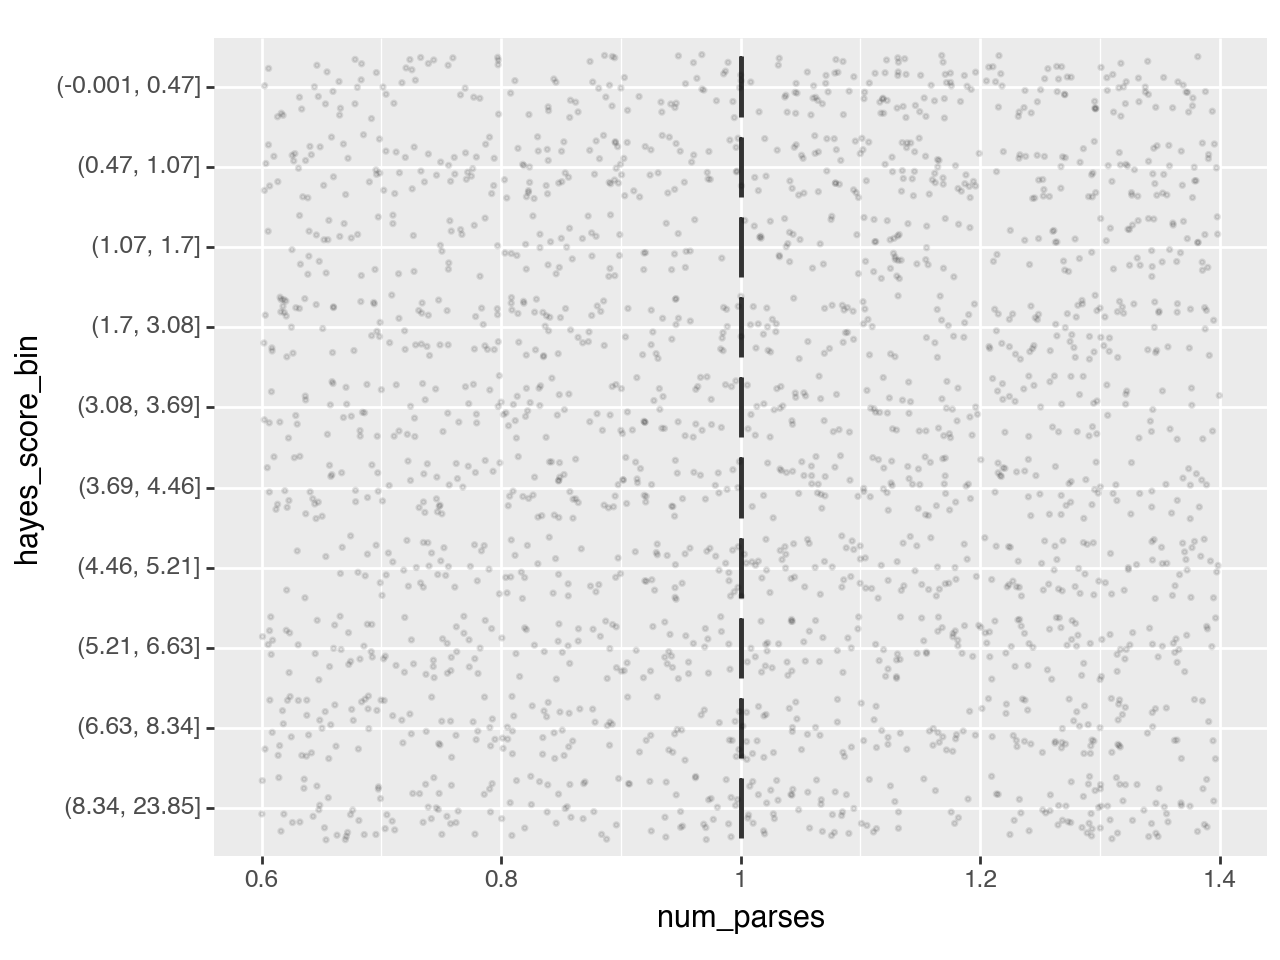

<Figure Size: (640 x 480)>

In [19]:
plot('hayes_score_bin', 'num_parses')

In [14]:
plot('num_parses_bin', 'hayes_score')

PlotnineError: "Could not evaluate the 'x' mapping: 'num_parses_bin' (original error: name 'num_parses_bin' is not defined)"

In [ ]:
plot('hayes_score_bin', 'num_viols')

In [ ]:
plot('num_viols_bin', 'hayes_score')